In [15]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [16]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Global Parameters:

In [17]:
# Working directory
parentDir = 'dftest'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [18]:
BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [31]:
def get_sampling_params(scale=.05, value=0.28):
    
    Cx_dMSN_NMDA_L = 0.063
    Cx_dMSN_NMDA_R = 0.063
    Cx_iMSN_NMDA_L = 0.063
    Cx_iMSN_NMDA_R = 0.063
    
    Cx_dMSN_AMPA_L = 0.1286
    Cx_dMSN_AMPA_R = 0.1286
    Cx_iMSN_AMPA_L = 0.1286
    Cx_iMSN_AMPA_R = 0.1286
    
    dMSN_iMSN = value #0.28
    D1STR_GPi = 1.10
    
    iMSN_dMSN  = 0.28
    D2STR_GPeP = 1.65
    
    GPe_STN = 0.4
    GPe_GPi = 0.012
    
    STN_GPi    =    0.0324
    
    GPi_Th     =    0.067
    
    Th_STRd = 0.255
    Th_STRi = 0.255
    
    
    
    CxTh       =    0.03
    CxFSI      =    0.165*.8
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    ThCx       =    0.02
    
    
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STRd': X['Cx']['STRd'][idx], 
        'STRi': X['Cx']['STRi'][idx],
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx],
           'D2STR': X['D1STR']['D2STR'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx],
           'D1STR_syn': X['D2STR']['D1STR_syn'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STRd': X['Th']['STRd'][idx], 
        'STRi': X['Th']['STRi'][idx],
        'Cx': X['Th']['Cx'][idx]}
    
    GPeP={'STN': X['GPeP']['STN'][idx],
          'GPi': X['GPeP']['GPi'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th, GPeP=GPeP)

# Sampe N_subj individual networks.

In [6]:
N_subj = 1
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff, preset = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Write simulation configuration files

In [17]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250
# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[55],
                               d2aw=[-45],
                               rewardprob=[1.0],
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7
                              )
sweepcount

1

# Run simulation

In [18]:
cores=4
ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)

# Create data-tables

In [19]:
# read in all population firing rates for all sims

results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
decisions = []
for sn in range(totalSim):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])

In [20]:
(paramtable,datatables) = gf.generateFrames(results,decisions)

# Phenotypes - find boundaries (connections 1 by 1)

In [33]:
NumSteps=20   #number of steps
eps=1     #discretization size

N_subj = 1
sdScale = .05
conProb = ng.getConProb()

cores=4
np.random.seed(seed=np.random.randint(0,1000))

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250

for index in range(0,NumSteps):
    value= 0.0+index*eps     #fins 0.143 ok
    print('Step',index,' with value', value)
    
    # define parameters
    muEff, sdEff, preset = get_sampling_params(sdScale,value)
    X = sample_network_efficacies(muEff, sdEff, N=N_subj)
    subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
    
    # get conn. efficacies for 1st subject network (idx=0)
    idx = 0
    conEff_i = subj_eff_dicts[idx]

    # configure trial and network parameters
    sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[55],
                               d2aw=[-45],
                               rewardprob=[1.0],
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7
                              )
    sweepcount
    
    # run the simulation
    ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)
    
    results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
    decisions = []
    for sn in range(totalSim):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs2(result)['decision made'])
            
    (paramtable,datatables) = gf.generateFrames(results,decisions)
    dd=datatables[0].decisionduration[0:50]
    d=datatables[0].decision[0:50]
    dratio=(sum(d)/len(d))*100  # d contains 0=action is given; 1=action is NON given
    print(dratio) # % of non-decisions
#    print(d)
    if dratio >= 30: # It fails if we have a 30% of non-decisions.
        print('The value', value, 'causes more than 30% of non-decisions')
    if max(dd) >= 300: # to be correct, the action decision time must be smaller than 150ms
        print('The value', value, 'causes a reaction time greater than the expected')
    if min(dd) <= 75: # to be correct, the action decision time must be greater than 75ms
        print('The value', value, 'causes a reaction time smaller than the expected')
    print(min(dd))
    print(max(dd))

Step 0  with value 0.0
Waiting for subprocess to end
Done
10.0
111.6943359375
130.8216552734375
Step 1  with value 1.0
Waiting for subprocess to end
Done
6.666666666666667
111.6943359375
149.02728271484375
Step 2  with value 2.0
Waiting for subprocess to end
Done
20.0
110.21484375
138.026611328125
Step 3  with value 3.0
Waiting for subprocess to end
Done
6.666666666666667
110.693359375
137.02655029296875
Step 4  with value 4.0
Waiting for subprocess to end
Done
0.0
109.21875
132.0262451171875
Step 5  with value 5.0
Waiting for subprocess to end
Done
6.666666666666667
107.6904296875
135.02642822265625
Step 6  with value 6.0
Waiting for subprocess to end
Done
20.0
109.6923828125
130.13671875
Step 7  with value 7.0
Waiting for subprocess to end
Done
3.3333333333333335
112.20703125
142.02685546875
Step 8  with value 8.0
Waiting for subprocess to end
Done
30.0
The value 8.0 causes more than 30% of non-decisions
111.6943359375
139.02667236328125
Step 9  with value 9.0
Waiting for subprocess 

# hddm

In [16]:
import hddm
hddm_savedir = os.path.join(os.path.expanduser('~'), 'hddm_fits')

data = bdf.reset_index(drop=True)
bias = True
inform = True
incl = ['z']
dependsCol = 'level'
nsamples = 2500
nburn = 1000

nullm = hddm.HDDM(data, bias=bias, include=incl, informative=inform)

freep = ['a', 't', 'v', 'z', 'va', 'vt', 'vz']
models = {}
for p in freep:
    plist = list(p)
    nfree = len(plist)
    depends = dict(zip(plist, [dependsCol]*nfree))
    m = hddm.HDDM(data, depends_on=depends, bias=bias, 
                  include=incl, informative=inform)
    models[p] = m

# Plots

In [ ]:
# Plot Population firing rates
results = ng.readAllTrialResults(8,0,sweepcount,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs'])
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1[0])
    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax1[1])
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[0])
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax3[2])

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

ax2[1].set_ylim(0,100)
ax1[1].set_ylim(0,100)

plt.savefig('FR_ramping.png', dpi=400)

In [17]:
for col in datatables[0].columns.values:
    print(col)

decision
stimulusstarttime
decisiontime
decisionduration
decisiondurationplusdelay
rewardtime
correctdecision
reward
msd_FSI_0
msd_LIPI_0
msd_GPi_0_0
msd_GPi_1_0
msd_STNE_0_0
msd_STNE_1_0
msd_GPeP_0_0
msd_GPeP_1_0
msd_D1STR_0_0
msd_D1STR_1_0
msd_D2STR_0_0
msd_D2STR_1_0
msd_LIP_0_0
msd_LIP_1_0
msd_Th_0_0
msd_Th_1_0
isd_FSI_0
isd_LIPI_0
isd_GPi_0_0
isd_GPi_1_0
isd_STNE_0_0
isd_STNE_1_0
isd_GPeP_0_0
isd_GPeP_1_0
isd_D1STR_0_0
isd_D1STR_1_0
isd_D2STR_0_0
isd_D2STR_1_0
isd_LIP_0_0
isd_LIP_1_0
isd_Th_0_0
isd_Th_1_0
mdr_FSI_0
mdr_LIPI_0
mdr_GPi_0_0
mdr_GPi_1_0
mdr_STNE_0_0
mdr_STNE_1_0
mdr_GPeP_0_0
mdr_GPeP_1_0
mdr_D1STR_0_0
mdr_D1STR_1_0
mdr_D2STR_0_0
mdr_D2STR_1_0
mdr_LIP_0_0
mdr_LIP_1_0
mdr_Th_0_0
mdr_Th_1_0
idr_FSI_0
idr_LIPI_0
idr_GPi_0_0
idr_GPi_1_0
idr_STNE_0_0
idr_STNE_1_0
idr_GPeP_0_0
idr_GPeP_1_0
idr_D1STR_0_0
idr_D1STR_1_0
idr_D2STR_0_0
idr_D2STR_1_0
idr_LIP_0_0
idr_LIP_1_0
idr_Th_0_0
idr_Th_1_0
msr_FSI_0
msr_LIPI_0
msr_GPi_0_0
msr_GPi_1_0
msr_STNE_0_0
msr_STNE_1_0
msr_GPeP_0_0
msr

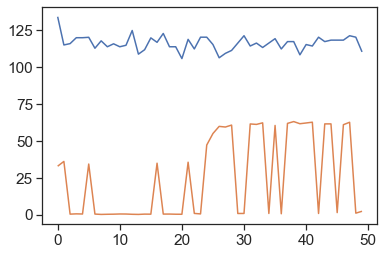

In [58]:
#x=datatables[0].decisiontime.to_string(index=False)
#print(x)
msr=datatables[0].msr_D1STR_1_0[0:50]
dt=datatables[0].decisiontime[0:50]
stt=datatables[0].stimulusstarttime[0:50]
#print(dt)
#y=list(dt)
#y2=list(stt)
plt.plot(dt-stt)
plt.plot(msr)